## Implementing parallelization in the code

In [54]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import pylab as plt
import MDAnalysis as md

In [55]:
from numba import jit, cuda
from timeit import default_timer as timer 
import multiprocessing


In [57]:


# particle itp

particle_type = {'base':{'type':'base','knn':0.01,'r_vdw':0.05,'charge':0, 'mass':2}}


# cell_itp

cell_type = {'base':{'type':'base', 'kc':0.01, 'radius':2, 'num_particles': 50, \
                     'particle_type':'base','n_neighbors':6}}



In [67]:


class Particle:
    def __init__(self, index = None, cell_index = None, position = np.zeros(3), p_type =particle_type['base']):
        
        self.index = index
        self.cell_index = cell_index
        self.p_type = p_type
        self.position = position
        self.mass = p_type['mass']
        self.r_vdw = p_type['r_vdw']



In [68]:
class Cell:
    def __init__(self, c_type = cell_type['base'], index = 0 , center_of_mass = np.zeros(3)):
        self.index = index
        self.c_type = c_type
        self.num_particles = self.c_type['num_particles']
        self.radius = self.c_type['radius']
        self.center_of_mass = center_of_mass
        self.n_neighbors = self.c_type['n_neighbors']
        self.particles = []
    
    @jit(nopython = True)                         
    def create_cell(self, start_index = 0):
        points = self.generate_initial_points()
        self.create_particles(points = points,start_index = start_index)
    
    @jit(nopython = True)                         
    def generate_initial_points(self):
        # Generate uniformly distributed points on the surface of a sphere using the Golden Spiral method
        golden_ratio = (1 + np.sqrt(5)) / 2
        theta = 2 * np.pi * np.arange(self.num_particles) / golden_ratio
        z = np.linspace(1 - 1.0 / self.num_particles, 1.0 / self.num_particles - 1, self.num_particles)
        radius = np.sqrt(1 - z * z)
        points = np.zeros((self.num_particles, 3))
        points[:, 0] = radius * np.cos(theta)
        points[:, 1] = radius * np.sin(theta)
        points[:, 2] = z
        points *= self.radius
        return points
                             
    def create_particles(self, start_index, points, ):
        for i, point in enumerate(points):
            particle = Particle(index = start_index + i, \
                                cell_index = self.index,\
                                position = point + self.center_of_mass, \
                                p_type = particle_type[self.c_type['particle_type']])
            self.particles.append(particle)

In [61]:
class System:
    def __init__(self, n_cells = 1, c_type ='base'):
        self.n_cells = n_cells
        self.c_type = cell_type[c_type]
        largest_vdw_radius = max([particle_type[ptype]['r_vdw'] for ptype in particle_type])
        self.largest_radius = max([cell_type[ctype]['radius'] for ctype in cell_type])
        self.largest_num_particles = max([cell_type[ctype]['num_particles'] for ctype in cell_type])
        self.cell_spacing = 1.5 * 2 * largest_vdw_radius + 2*self.largest_radius
        self.box_spacing = 5 * largest_vdw_radius
        self.vdw_cutoff = 1  #vdw_cutoff
        self.vdw_epsilon = 0.001 #vdw_epsilon
        self.vdw_sigma = 1 #vdw_sigma
        self.cells = []
        self.particles = []
        self.positions = []
        self.forces = []
        self.centers_of_mass = np.zeros((self.n_cells,3))
        self.cell_particle_indices = []
        
        # Create the system and the simulation box
        self.create_system()
        self.create_box()
        # Create bonded_neighbor and bonded_central interactions
        self.create_bonded_interactions()
        # turn the stuff into arrays
        self.bonded_central = np.array(self.bonded_central)
        self.bonded_neighbor = np.array(self.bonded_neighbor)
                             
    def create_system(self):
        # Calculate grid size based on number of cells
        grid_size = int(np.ceil(self.n_cells ** (1/3)))
        
        for i in range(grid_size):
            for j in range(grid_size):
                for k in range(grid_size):
                    if len(self.cells) < self.n_cells:
                        center_of_mass = [i * self.cell_spacing,
                                          j * self.cell_spacing,
                                          k * self.cell_spacing]
                        self.centers_of_mass[len(self.cells)] = center_of_mass
                        cell = Cell(c_type=self.c_type,
                                    index = len(self.cells),
                                    center_of_mass=center_of_mass)
                        cell.create_cell(start_index = len(self.cells)*self.c_type['num_particles'])
                        self.cells.append(cell)
                        self.particles.extend(cell.particles)
                        # Store particle indices for current cell
                        self.cell_particle_indices.append([particle.index for particle in cell.particles])
        # Initialize positions and forces arrays
        n_particles = len(self.particles)
        self.positions = np.zeros((n_particles, 3))
        self.forces = np.zeros((n_particles, 3))
        
        # Set initial positions of particles
        for i, particle in enumerate(self.particles):
            self.positions[i] = particle.position
                         
    def create_box(self):
        grid_size = int(np.ceil(self.n_cells ** (1/3)))
        
        # Calculate box dimensions based on grid size and cell spacing
        box_dimensions = np.array([grid_size, grid_size, grid_size]) * self.cell_spacing

        # Add box spacing to box dimensions to ensure that box walls are away from outermost 
        # cell particles by box spacing distance
        box_dimensions += 2 * self.box_spacing

        # Calculate center of mass of system
        system_center_of_mass = np.mean(self.positions, axis=0)

        # Move system center of mass to box center
        box_center = box_dimensions / 2
        translation_vector = box_center - system_center_of_mass
        self.positions += translation_vector
        for cell in self.cells:
            cell.center_of_mass += translation_vector
            for particle in cell.particles:
                particle.position += translation_vector

        self.box_dimensions = box_dimensions
    
    @jit(nopython = True)                         
    def create_bonded_interactions(self):
        # Initialize bonded_neighbor and bonded_central interactions
        self.bonded_neighbor = []
        self.bonded_central = []

        # Loop over cells to create interactions
        for cell in self.cells:
            n_neighbors = cell.n_neighbors
            # Create an array of particle positions for the current cell
            positions = np.array([particle.position for particle in cell.particles])

            # Find the N nearest neighbors for each particle in the current cell
            nbrs = NearestNeighbors(n_neighbors=n_neighbors+1).fit(positions)
            distances, indices = nbrs.kneighbors(positions)

            # Loop over particles in the current cell to create interactions
            for i, particle in enumerate(cell.particles):
                # Create bonded_central interaction
                kc = cell.c_type['kc']
                r0 = cell.c_type['radius']
                self.bonded_central.append([particle.index, -1, kc, r0])

                # Create bonded_neighbor interactions
                for j in indices[i][1:]:
                    if particle.index < cell.particles[j].index:
                        neighbor_particle = cell.particles[j]
                        k = knn = particle.p_type['knn']
                        r0 = 2*self.largest_radius /np.sqrt(self.largest_num_particles) 
                        #(particle.r_vdw + neighbor_particle.r_vdw) / 2
                        self.bonded_neighbor.append([int(particle.index), int(neighbor_particle.index), k, r0])
                    
    @jit(nopython = True)                         
    def calculate_bonded_forces(self):
        # Reset forces to zero
        self.forces.fill(0)

        # Calculate forces from bonded_central interactions
        particle_indices = self.bonded_central[:, 0].astype(np.int64)
        ks = self.bonded_central[:, 2]
        r0s = self.bonded_central[:, 3]
        particle_positions = self.positions[particle_indices]

        # Update center of mass of each cell
        cell_center_of_masses = np.array([np.mean(self.positions[cell_particle_indices], axis=0) \
                                          for cell_particle_indices in self.cell_particle_indices])
        # Select center of mass for each particle in particle_indices
        cell_center_of_masses = np.array([cell_center_of_masses[self.particles[i].cell_index] for i in particle_indices])
        rijs = particle_positions - cell_center_of_masses
        # Apply minimum image convention
        rijs -= np.rint(rijs / self.box_dimensions) * self.box_dimensions
        dijs = np.linalg.norm(rijs, axis=1)
        fijs = -ks[:, None] * (dijs - r0s)[:, None] * rijs / dijs[:, None]
        np.add.at(self.forces, particle_indices, fijs)

        # Calculate forces from bonded_neighbor interactions
        particle_indices = self.bonded_neighbor[:, 0].astype(np.int64)
        neighbor_particle_indices = self.bonded_neighbor[:, 1].astype(np.int64)
        ks = self.bonded_neighbor[:, 2]
        r0s = self.bonded_neighbor[:, 3]
        particle_positions = self.positions[particle_indices]
        neighbor_particle_positions = self.positions[neighbor_particle_indices]
        rijs = particle_positions - neighbor_particle_positions
        # Apply minimum image convention
        rijs -= np.rint(rijs / self.box_dimensions) * self.box_dimensions
        dijs = np.linalg.norm(rijs, axis=1)
        fijs = -ks[:, None] * (dijs - r0s)[:, None] * rijs / dijs[:, None]
        np.add.at(self.forces, particle_indices, fijs)
        np.subtract.at(self.forces, neighbor_particle_indices, fijs)

    @jit(nopython = True)                            
    def calculate_vdw_forces(self):
        # Calculate pairwise distances between particles
        rij = self.positions[:, np.newaxis, :] - self.positions[np.newaxis, :, :]
        # Apply minimum image convention
        rij -= np.rint(rij / self.box_dimensions) * self.box_dimensions
        dij = np.linalg.norm(rij, axis=2)

        # Calculate van der Waals forces
        fij = np.zeros_like(rij)
        mask = (dij > 0) & (dij < self.vdw_cutoff)
        fij[mask] = 24 * self.vdw_epsilon * ((2 * (self.vdw_sigma / dij[mask]) ** 12) - \
                                             ((self.vdw_sigma / dij[mask]) ** 6))[:, np.newaxis] \
                                            * rij[mask] / dij[mask][:, np.newaxis]

        # Sum van der Waals forces acting on each particle
        vdw_forces = np.sum(fij, axis=1)

        return vdw_forces
    
    @jit(nopython = True)                         
    def potential_energy(self, verbose=False):
        # Calculate potential energy from bonded_central interactions
        particle_indices = self.bonded_central[:, 0].astype(int)
        ks = self.bonded_central[:, 2]
        r0s = self.bonded_central[:, 3]
        particle_positions = self.positions[particle_indices]
        cell_center_of_masses = np.array([self.cells[self.particles[i].cell_index].\
                                          center_of_mass for i in particle_indices])
        #dijs = np.linalg.norm(particle_positions - cell_center_of_masses, axis=1)
        rijs = particle_positions - cell_center_of_masses
        # Apply minimum image convention
        rijs -= np.rint(rijs / self.box_dimensions) * self.box_dimensions
        dijs = np.linalg.norm(rijs, axis=1)
        central_pe = 0.5 * np.sum(ks * (dijs - r0s) ** 2)
        pe = 0.5 * np.sum(ks * (dijs - r0s) ** 2)

        # Calculate potential energy from bonded_neighbor interactions
        particle_indices = self.bonded_neighbor[:, 0].astype(int)
        neighbor_particle_indices = self.bonded_neighbor[:, 1].astype(int)
        ks = self.bonded_neighbor[:, 2]
        r0s = self.bonded_neighbor[:, 3]
        particle_positions = self.positions[particle_indices]
        neighbor_particle_positions = self.positions[neighbor_particle_indices]
        rijs = particle_positions - neighbor_particle_positions
        # Apply minimum image convention
        rijs -= np.rint(rijs / self.box_dimensions) * self.box_dimensions
        dijs = np.linalg.norm(rijs, axis=1)
        #dijs = np.linalg.norm(particle_positions - neighbor_particle_positions, axis=1)
        bonded_pe = 0.5 * np.sum(ks * (dijs - r0s) ** 2)
        pe += bonded_pe
        
        # Calculate van der Waals potential energy
        rij = self.positions[:, np.newaxis, :] - self.positions[np.newaxis, :, :]
        # Apply minimum image convention
        rij -= np.rint(rij / self.box_dimensions) * self.box_dimensions
        dij = np.linalg.norm(rij, axis=2)
        mask = (dij > 0) & (dij < self.vdw_cutoff)
        vdw_pe = 4 * self.vdw_epsilon * np.sum(((self.vdw_sigma / dij[mask]) ** 12) - \
                                               ((self.vdw_sigma / dij[mask]) ** 6))
        pe += vdw_pe
        if not verbose:
            return pe
        else: return pe, central_pe, bonded_pe, vdw_pe

    @jit(nopython = True)                         
    def kinetic_energy(self, velocities):
        masses = np.array([particle.mass for particle in self.particles])
        return 0.5 * np.sum(masses[:, None] * velocities ** 2)

In [62]:
@jit(target_backend='cuda', nopython = True)                         
def minimize_energy(system, dt=0.0001, n_steps=1000, verbose=False):
    energies = []
    for step in range(n_steps):
        # Calculate potential energy
        pe = system.potential_energy()
        energies.append(pe)

        #if verbose:
            #Numba does not support f strings
            #print("Step:" + step ", Potential Energy:" + pe + ", end='\r'")

        # Calculate the forces acting on the particles
        system.calculate_bonded_forces()
        bonded_forces = system.forces
        vdw_forces = system.calculate_vdw_forces()
        forces = bonded_forces + vdw_forces

        # Update the positions of the particles
        system.positions += dt * forces

    # Update center of mass of each cell
    for cell in system.cells:
        cell_center_of_mass = np.mean([particle.position for particle in cell.particles], axis=0)
        cell.center_of_mass = cell_center_of_mass

    # Update positions
    for i, particle in enumerate(system.particles):
        particle.position = system.positions[i]

    return energies

In [63]:
@jit(target_backend='cuda', nopython = True)                         
def simulate_dynamics(system, dt=0.1, n_steps=1000, initial_velocities=None, temperature=0.1, verbose=False\
                      ,skip=100, out_trj = 'trjout.xtc'):
    n_particles = len(system.particles)
    masses = np.array([particle.mass for particle in system.particles])
    if initial_velocities is None:
        velocities = np.zeros((n_particles, 3))
    elif initial_velocities == "MB":
        velocities = np.random.normal(0, np.sqrt(temperature), (n_particles, 3))
    else:
        velocities = initial_velocities

    penergy = system.potential_energy()
    kenergy = system.kinetic_energy(velocities)
    PDB = f'system_{system.n_cells}cells_min.pdb'
    u = md.Universe(PDB)
    protein = u.select_atoms("name CA")
    with md.Writer( out_trj, protein.n_atoms) as W:
        penergy_trajectory = []
        kenergy_trajectory = []
        for i in range(n_steps):
            # Remove center of mass motion
            com_velocity = np.sum(masses[:, None] * velocities, axis=0) / np.sum(masses)
            velocities -= com_velocity

            # Calculate forces
            system.calculate_bonded_forces()
            bonded_forces = system.forces
            vdw_forces = system.calculate_vdw_forces()
            forces = bonded_forces + vdw_forces

            # Update positions
            system.positions += velocities * dt + 0.5 * forces * dt ** 2 / masses[:, None]

            # Apply periodic boundary conditions
            system.positions = system.positions % system.box_dimensions

            # Calculate new forces
            system.calculate_bonded_forces()
            new_forces = system.forces

            # Update velocities
            velocities += 0.5 * (forces + new_forces) * dt / masses[:, None]
            
            if i%100 == 0:
                # Record trajectory and energies
                penergy, central, bonded, vdw = system.potential_energy(verbose=True)
                kenergy = system.kinetic_energy(velocities)
                penergy_trajectory.append([penergy,central, bonded,vdw])
                kenergy_trajectory.append(kenergy)
                protein.atoms.positions = system.positions
                W.write(protein)

                if verbose:
                    print(f'Iteration: {i}, Potential Energy: {penergy}',end='\r')

        # Update center of mass of each cell
        for cell in system.cells:
            cell_center_of_mass = np.mean([particle.position for particle in cell.particles], axis=0)
            cell.center_of_mass = cell_center_of_mass
        # Update positions
        for i, particle in enumerate(system.particles):
            particle.position = system.positions[i]

        return np.array(kenergy_trajectory), np.array(penergy_trajectory)

In [26]:
@jit(target_backend='cuda', nopython = True)                         
def simulate_nvt_dynamics(system, dt=0.1, n_steps=1000, initial_velocities=None, temperature=0.1,
                       collision_frequency=10.0, verbose=False, out_trj = 'trjout.xtc'):
    n_particles = len(system.particles)
    masses = np.array([particle.mass for particle in system.particles])
    if initial_velocities is None:
        velocities = np.zeros((n_particles, 3))
    elif initial_velocities == "MB":
        velocities = np.random.normal(0, np.sqrt(temperature), (n_particles, 3))
    else:
        velocities = initial_velocities

    PDB = f'system_{system.n_cells}cells_min.pdb'
    u = md.Universe(PDB)
    protein = u.select_atoms("name CA")
    
    penergy_trajectory = []
    kenergy_trajectory = []
    
    with md.Writer( out_trj, protein.n_atoms) as W:
        for i in range(n_steps):
            # Remove center of mass motion
            velocities -= np.sum(masses[:, None] * velocities, axis=0) / np.sum(masses)

            # Calculate forces
            system.calculate_bonded_forces()
            bonded_forces = system.forces
            vdw_forces = system.calculate_vdw_forces()
            forces = bonded_forces + vdw_forces

            # Update positions
            system.positions += velocities * dt + 0.5 * forces * dt ** 2 / masses[:, None]

            # Apply periodic boundary conditions
            system.positions = system.positions % system.box_dimensions

            # Calculate new forces
            system.calculate_bonded_forces()
            new_forces = system.forces

            # Update velocities
            velocities += 0.5 * (forces + new_forces) * dt / masses[:, None]

            # Apply Andersen thermostat
            collision_prob = 1 - np.exp(-collision_frequency * dt)
            collision_mask = np.random.random(n_particles) < collision_prob
            velocities[collision_mask] = np.random.normal(0, np.sqrt(temperature), (np.sum(collision_mask), 3))
            
            if i%100 == 0:
                # Record trajectory and energies
                penergy, central, bonded, vdw = system.potential_energy(verbose=True)
                kenergy = system.kinetic_energy(velocities)
                penergy_trajectory.append([penergy,central, bonded,vdw])
                kenergy_trajectory.append(kenergy)
                protein.atoms.positions = system.positions
                W.write(protein)
                
                if verbose:
                    print(f'Iteration: {i}, Potential Energy: {penergy}',end='\r')

        return np.array(kenergy_trajectory), np.array(penergy_trajectory)


In [64]:
@jit(target_backend='cuda', nopython = True)                         
def simulate_npt_dynamics(system, dt=0.1, n_steps=1000, initial_velocities=None, temperature=0.1,
                          collision_frequency=10.0, pressure=1.0, barostat_frequency=10,
                          verbose=False, out_trj='trjout.xtc'):
    n_particles = len(system.particles)
    masses = np.array([particle.mass for particle in system.particles])
    if initial_velocities is None:
        velocities = np.zeros((n_particles, 3))
    elif initial_velocities == "MB":
        velocities = np.random.normal(0, np.sqrt(temperature), (n_particles, 3))
    else:
        velocities = initial_velocities

    PDB = f'system_{system.n_cells}cells_min.pdb'
    u = md.Universe(PDB)
    protein = u.select_atoms("name CA")

    penergy_trajectory = []
    kenergy_trajectory = []

    with md.Writer(out_trj, protein.n_atoms) as W:
        for i in range(n_steps):
            # Remove center of mass motion
            com_velocity = np.sum(masses[:, None] * velocities, axis=0) / np.sum(masses)
            velocities -= com_velocity

            # Calculate forces
            system.calculate_bonded_forces()
            bonded_forces = system.forces
            vdw_forces = system.calculate_vdw_forces()
            forces = bonded_forces + vdw_forces

            # Update positions
            system.positions += velocities * dt + 0.5 * forces * dt ** 2 / masses[:, None]

            # Apply periodic boundary conditions
            system.positions = system.positions % system.box_dimensions

            # Calculate new forces
            system.calculate_bonded_forces()
            new_forces = system.forces

            # Update velocities
            velocities += 0.5 * (forces + new_forces) * dt / masses[:, None]

            # Apply Andersen thermostat
            collision_prob = 1 - np.exp(-collision_frequency * dt)
            collision_mask = np.random.random(n_particles) < collision_prob
            velocities[collision_mask] = np.random.normal(0, np.sqrt(temperature), (np.sum(collision_mask), 3))

            # Apply Monte Carlo barostat
            if i % barostat_frequency == 0:
                volume = np.prod(system.box_dimensions)
                old_energy = system.potential_energy()
                delta_volume = np.random.uniform(-0.1 * volume, 0.1 * volume)
                new_volume = volume + delta_volume
                scaling_factor = (new_volume / volume) ** (1 / 3)
                system.box_dimensions *= scaling_factor
                u.dimensions[:3] = system.box_dimensions
                system.positions *= scaling_factor
                new_energy = system.potential_energy()
                delta_energy = new_energy - old_energy
                acceptance_probability = np.exp(-delta_energy / temperature) * (new_volume / volume) ** (
                            n_particles + 1) * np.exp(-pressure * delta_volume / temperature)
                if np.random.random() > acceptance_probability:
                    system.box_dimensions /= scaling_factor
                    system.positions /= scaling_factor

            if i % 100 == 0:
                # Record trajectory and energies
                penergy, central, bonded, vdw = system.potential_energy(verbose=True)
                kenergy = system.kinetic_energy(velocities)
                penergy_trajectory.append([penergy, central, bonded, vdw])
                kenergy_trajectory.append(kenergy)
                protein.atoms.positions = system.positions
                W.write(protein)
                #instantaneous_pressure = (2 * kenergy - 3 * (kenergy+penergy)) / (3 * volume)
                #instantaneous_temperature = (2 * kenergy) / (3 * n_particles * k_B)

                if verbose:
                    print(f'Iteration: {i}, Potential Energy: {penergy}', end='\r')

        return np.array(kenergy_trajectory), np.array(penergy_trajectory)


In [65]:
def write_pdb(system, filename):
    with open(filename, 'w') as f:
        # Write box dimensions to PDB file
        f.write(f"CRYST1{system.box_dimensions[0]:9.3f}{system.box_dimensions[1]:9.3f\
}{system.box_dimensions[2]:9.3f}  90.00  90.00  90.00 P 1           1\n")

        # Write particle coordinates to PDB file
        atom_index = 1
        for cell_index, cell in enumerate(system.cells):
            chain_id = chr(cell_index + 65)  # Convert cell index to chain ID (A,B,C,...)

            for particle in cell.particles:
                x, y, z = particle.position
                f.write(f"HETATM{atom_index:>5}  CA  ALA {chain_id}{atom_index:>4\
}    {x:>8.3f}{y:>8.3f}{z:>8.3f}  1.00 20.00           C  \n")
                atom_index += 1
            f.write(f"TER\n")



In [66]:


# particle itp

particle_type = {'base':{'type':'base','knn':0.01,'r_vdw':0.05,'charge':0, 'mass':1}}


# cell_itp

cell_type = {'base':{'type':'base', 'kc':0.5, 'radius':2, 'num_particles': 100, \
                     'particle_type':'base','n_neighbors':6}}

# Create a system with 8 cells
n_cells = 4
system = System(n_cells=n_cells)
write_pdb(system,f'system_{n_cells}cells.pdb')



TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_355986/3727326692.py (11)[0m
[1m
File "../../../../tmp/ipykernel_355986/3727326692.py", line 11:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.Cell'>[0m


In [30]:
system.potential_energy(verbose=True)

(36025.89297257298,
 1.7589132996099748e-29,
 0.9725372420865276,
 36024.920435330896)

In [53]:
energies = minimize_energy(system,verbose=True, n_steps= 100)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1mnon-precise type pyobject[0m
[0m[1mDuring: typing of argument at /tmp/ipykernel_355986/1786975552.py (1)[0m
[1m
File "../../../../tmp/ipykernel_355986/1786975552.py", line 1:[0m
[1m<source missing, REPL/exec in use?>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.System'>[0m 

This error may have been caused by the following argument(s):
- argument 0: [1mCannot determine Numba type of <class '__main__.System'>[0m


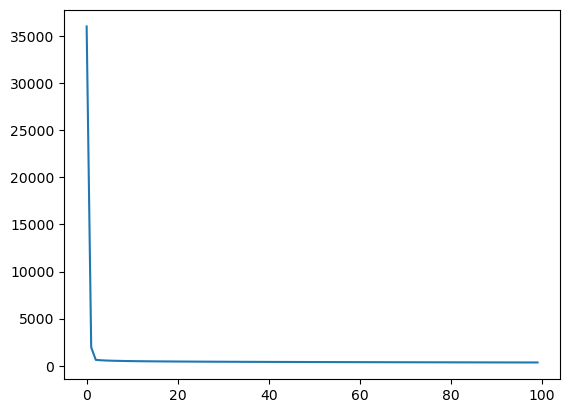

In [32]:
plt.plot(energies)

In [33]:
write_pdb(system,f'system_{system.n_cells}cells_min.pdb')

In [34]:


ke, pe = simulate_dynamics(system,n_steps = 1000, verbose=True, dt = 0.001, \
                                 temperature = 0.01, initial_velocities='MB', \
                           out_trj = f'system_{system.n_cells}cells_nve_eq.xtc')
#
#



UnsupportedError: Failed in object mode pipeline (step: analyzing bytecode)
[1mThe 'with (context manager) as (variable):' construct is not supported.[0m

In [ ]:


plt.plot(pe[:,0], label = 'Total PE')
plt.plot(ke, label = 'Total KE')
plt.legend()



In [ ]:
plt.plot(ke)
plt.plot((pe[:,0]+ke))

In [ ]:


ke, pe = simulate_nvt_dynamics(system,n_steps = 1000, verbose=True, dt = 0.01, \
                                 temperature = 0.01, initial_velocities='MB', \
                           out_trj = f'system_{system.n_cells}cells_nvt_prod.xtc')
#
#



In [ ]:
plt.plot(pe[:,1], label = 'Central PE')
plt.plot(pe[:,2], label = 'Bonded PE')
plt.plot(pe[:,3], label = 'VdW PE')
plt.legend()


In [ ]:
plt.plot(ke)
plt.plot((pe[:,0]+ke))

In [ ]:


ke, pe = simulate_npt_dynamics(system,n_steps = 100000, verbose=True, dt = 0.1, \
                                 temperature = 0.01, pressure= 0.04, initial_velocities='MB', \
                           out_trj = f'system_{system.n_cells}cells_npt_prod.xtc')
#
#



In [ ]:


plt.plot(pe[:,1], label = 'Central PE')
plt.plot(pe[:,2], label = 'Bonded PE')
plt.plot(pe[:,3], label = 'VdW PE')
plt.legend()



In [ ]:
plt.plot(ke)
plt.plot((pe[:,0]+ke))
